In [1]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

In [2]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()
    return fix_df

In [3]:
# 补全缺失数据
def fix_zero(df,index):
    df[index]=df[index].replace(0.00, np.NaN)
    df[index]=df[index].fillna(df[index].median())
    return df

In [4]:
# 读取数据
his_nmp_gf_df = pd.read_csv('.\\data\\GF001\\03 His_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_power_gf_df = pd.read_csv('.\\data\\GF001\\02 His_Power_GF.csv',parse_dates=["Datetime"],index_col=[0])
his_gf_df=preprocessing(his_nmp_gf_df,his_power_gf_df)
his_gf_df.to_csv('his_gf.csv',encoding = 'utf-8') #存储合并后数据

In [5]:
df=pd.read_csv('his_gf.csv',parse_dates=["Datetime"],index_col=[0])

In [6]:
# df.drop('Pressure', axis=1, inplace=True)
df=fix_zero(df,'Humidity')

In [7]:
df_feaformm=pd.read_csv('.\\data\\GF001\\04 Fore_NWP_GF.csv',parse_dates=["Datetime"],index_col=[0])
df_feaformm["Power(MW)"]=np.NaN
# df_feaformm.drop('Pressure', axis=1, inplace=True)
df_feaformm=fix_zero(df_feaformm,'Humidity')

In [8]:
df.describe()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
count,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000,672.000000
mean,165.780134,7.026755,30.521442,27.960625,998.217932,88.431562,16.176073
std,241.727042,1.847183,40.005602,0.855548,1.282430,4.835594,20.495197
min,0.000000,1.073300,1.766300,25.570000,995.650000,74.250000,0.000000
25%,0.000000,5.992900,18.236475,27.362500,997.140000,84.895000,0.000000
50%,11.550000,7.254050,24.890850,27.790000,998.235000,89.325000,1.448000
75%,277.922500,8.580775,32.774250,28.632500,999.010000,91.622500,33.591475
max,853.600000,9.976500,357.823400,29.760000,1000.970000,99.800000,66.660900


In [9]:
# 划分train valid test集
gf_df_train = df[:int(0.6*len(df))]
gf_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
gf_df_test =df[int(0.8*len(df)):]

In [10]:
gf_df_test_copy=gf_df_test.copy()
full_df_fea=gf_df_test_copy.append(df_feaformm)
full_df_fea.to_csv('full_df_fea.csv',encoding = 'utf-8')

C:\Users\23966\AppData\Local\Temp\ipykernel_18364\3533464468.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_fea=gf_df_test_copy.append(df_feaformm)


In [11]:
# 定义一个新的归一化函数
def simla(stand_df,df):
    train_median1=stand_df['Irradiance'].median()
#     print('Irradiance',train_median1)
    train_median2=stand_df['Speed10'].median()
#     print('Speed10',train_median2)
    train_median3=stand_df['Direction10'].median()
#     print('Direction10',train_median3)
    train_median4=stand_df['Temper'].median()
#     print('Temper',train_median4)
    train_median6=stand_df['Humidity'].median()
#     print('Humidity',train_median6)
    train_median5=stand_df['Pressure'].median()
#     print('Pressure',train_median5)
    train_median7=stand_df['Power(MW)'].median()
#     print('Power(MW)',train_median7)
    df_copy=df.copy()
    df_copy['Irradiance']=df['Irradiance']/train_median1
    df_copy['Speed10']=df['Speed10']/train_median2
    df_copy['Direction10']=df['Direction10']/train_median3
    df_copy['Temper']=df['Temper']/train_median4
    df_copy['Humidity']=df['Humidity']/train_median6
    df_copy['Pressure']=df['Pressure']/train_median5
    df_copy['Power(MW)']=df['Power(MW)']/33
    return df_copy

In [12]:
# 定义一个反归一化函数
def Denormalization(stand_df,df):
    train_median=stand_df['Power(MW)'].median()
#     print('Power(MW)',train_median)
    df_copy=df.copy()
    df_copy=df*33
    return df_copy

In [13]:
df_for_training_scaled = simla(df,gf_df_train).values
df_for_validing_scaled=simla(df,gf_df_valid).values
df_for_testing_scaled=simla(df,gf_df_test).values

In [14]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

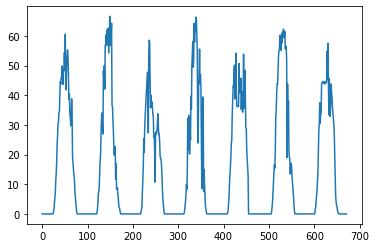

In [15]:
# 看一下历史波形
plt.plot(range(len(df['Power(MW)'])), df['Power(MW)'], label='history')

In [16]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [17]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=size))
#     grid_model.add(tf.keras.layers.Flatten())
#     grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
#     grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
    grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
    grid_model.add(tf.keras.layers.Dense(size))
#     grid_model.add(tf.keras.layers.Dropout(0.2))
    grid_model.add(tf.keras.layers.Dense(1))
    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    return grid_model

In [18]:
# 准备一些copy用用
df_for_testing_scaled_forpred=df_for_testing_scaled.copy()
df_for_testing_scaled_inloop=df_for_testing_scaled.copy()

df_for_testing_scaled_forpred=pd.DataFrame(df_for_testing_scaled_forpred)
df_for_testing_scaled_inloop=pd.DataFrame(df_for_testing_scaled_inloop)

df_for_testing_scaled_forpred_array=df_for_testing_scaled_forpred.values
df_for_testing_scaled_inloop_array=df_for_testing_scaled_inloop.values

df_for_testing_scaled_inloop.iloc[7:,-1]=np.nan

In [19]:
# 准备一些copy用用
df_for_validing_scaled_forpred=df_for_validing_scaled.copy()
df_for_validing_scaled_inloop=df_for_validing_scaled.copy()

df_for_validing_scaled_forpred=pd.DataFrame(df_for_validing_scaled_forpred)
df_for_validing_scaled_inloop=pd.DataFrame(df_for_validing_scaled_inloop)

df_for_validing_scaled_forpred_array=df_for_validing_scaled_forpred.values
df_for_validing_scaled_inloop_array=df_for_validing_scaled_inloop.values

df_for_validing_scaled_inloop.iloc[7:,-1]=np.nan

In [20]:
df_for_testing_scaled_inloop.to_csv('df_for_testing_scaled_inloop.csv',encoding = 'utf-8') #存储合并后数据

In [21]:
# 为循环初始化一些数据
bestscore=1000
flag=0
num=0
best_size=0
best_batch_size=0
best_epochs=0
time_step=7

In [ ]:
# 开始循环（warning不影响做）
for size in[8]:
    for batch_size in [32]:
        for epochs in [20,30]:
            grid_model=build_model(size)
            grid_model.fit(
            train_X, train_y,
            validation_data=(valid_X, valid_y),
            batch_size=32,
            epochs=epochs,
            verbose=0)
            all_data_test=[]
            all_data_valid=[]
# 此处用了和feature一样的逐点预测方法
            for i in range (time_step,len(df_for_testing_scaled_inloop_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_inloop_array[i-time_step :i , 0:df_for_testing_scaled_inloop.shape[1]])
                 data_x=np.array(data_x)
                 prediction=grid_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_inloop.iloc[i,-1]=prediction
            for i in range (time_step,len(df_for_validing_scaled_inloop_array)) :
                 data_x=[]
                 data_x.append( df_for_validing_scaled_inloop_array[i-time_step :i , 0:df_for_validing_scaled_inloop.shape[1]])
                 data_x=np.array(data_x)
                 prediction=grid_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_valid.append(prediction)
                 df_for_validing_scaled_inloop.iloc[i,-1]=prediction
            score=ev(test_y,np.array(all_data_test))+ev(valid_y,np.array(all_data_valid))
            print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
            num=num+1
            if score<bestscore:
                flag=1
                bestscore=score
                print(bestscore)
                best_size=size
                best_batch_size=batch_size
                best_epochs=epochs
                # Export the model to a SavedModel
                grid_model.save('keras_model_tf_version', save_format='tf')
print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

C:\Users\23966\AppData\Local\Temp\ipykernel_18364\1339532669.py:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  score=ev(test_y,np.array(all_data_test))+ev(valid_y,np.array(all_data_valid))


num: 0 score= 58.23879051208496 size= 8 batch_size= 32 epochs= 20
58.23879051208496


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


INFO:tensorflow:Assets written to: keras_model_tf_version\assets


In [ ]:
for i in range (time_step,len(df_for_validing_scaled_inloop_array)) :
                 data_x=[]
                 data_x.append( df_for_validing_scaled_inloop_array[i-time_step :i , 0:df_for_validing_scaled_inloop.shape[1]])
                 data_x=np.array(data_x)
                 prediction=grid_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_valid.append(prediction)
                 df_for_validing_scaled_inloop.iloc[i,-1]=prediction

In [ ]:
# 加载最佳模型
my_model = tf.keras.models.load_model('keras_model_tf_version')

In [ ]:
# 用最佳模型预测一下test
all_data_test=[]
for i in range (time_step,len(df_for_testing_scaled_forpred_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_forpred_array[i-time_step :i , 0:df_for_testing_scaled_forpred.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_forpred.iloc[i,-1]=prediction
print(ev(test_y,np.array(all_data_test)))
# 看看test的结果
plt.plot(range(len(all_data_test)), all_data_test, label='Prediction')
plt.plot(range(len(test_y)), test_y, label='Prediction')

In [ ]:
# 用最佳模型预测一下valid
all_data_valid=[]
for i in range (time_step,len(df_for_validing_scaled_forpred_array)) :
                 data_x=[]
                 data_x.append( df_for_validing_scaled_forpred_array[i-time_step :i , 0:df_for_validing_scaled_forpred.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_valid.append(prediction)
                 df_for_validing_scaled_forpred.iloc[i,-1]=prediction
                    # 看看valid的结果
plt.plot(range(len(all_data_valid)), all_data_valid, label='Prediction')
plt.plot(range(len(valid_y)), valid_y, label='Prediction')

In [ ]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
print(ev(valid_y,pred_valid_y))
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [ ]:
# 查看test集预测结果
pred_test_y = my_model.predict(test_X)
print(ev(test_y,pred_test_y))
plt.plot(range(len(pred_test_y)), pred_test_y, label='Prediction')
plt.plot(range(len(pred_test_y)), test_y, label='Ground Truth')
plt.fill_between(range(len(pred_test_y)), pred_test_y.flatten(), test_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [ ]:
df_fea=pd.read_csv('full_df_fea.csv',index_col=[0])
df_fea=simla(df,df_fea)
df_fea

In [ ]:
df_fea_array=df_fea.values

In [ ]:
# 用最佳模型预测一下fea
all_data_fea=[]
for i in range (time_step,len(df_fea_array)) :
                 data_x=[]
                 data_x.append( df_fea_array[i-time_step :i , 0:df_fea.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_fea.append(prediction)
                 df_fea.iloc[i,-1]=prediction


In [ ]:
plt.plot(range(len(all_data_fea)), np.array(all_data_fea).flatten(), label='Prediction')

In [ ]:
all_data_fea_Denormalization=Denormalization(df,pd.DataFrame(all_data_fea))
all_data_fea_Denormalization

In [ ]:
plt.plot(range(len(all_data_fea_Denormalization)), np.array(all_data_fea_Denormalization).flatten(), label='Prediction')